In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from pymongo import MongoClient
from bson.objectid import ObjectId
from datetime import timedelta
from scipy.stats import wilcoxon, mannwhitneyu, combine_pvalues
from cliffs_delta import cliffs_delta
import numpy as np
import datetime
import re
client = MongoClient()
db = client.smartshark_2_2
vcs_systems = pd.DataFrame(list(db.vcs_system.find()))
travisBuilds = pd.DataFrame(list(db.travis_build.find()))
tags = pd.DataFrame(list(db.tag.find()))
issues = pd.DataFrame(list(db.issue.find()))

In [2]:
# IC
projetosComBuilds = travisBuilds['vcs_system_id'].unique()

# Tags of project with IC
idsVcsComBuilds = vcs_systems.query('_id.isin(@projetosComBuilds)').drop_duplicates().dropna()._id
tagsDosProjComBuild = tags.query('vcs_system_id.isin(@idsVcsComBuilds)').drop_duplicates().dropna()

#Release Tags
tagsDeRelase = tagsDosProjComBuild[
    tagsDosProjComBuild['name']
    .str.contains('rc|RC|candidate|CANDIDATE|beta|BETA|alpha|ALPHA')==False].drop_duplicates().dropna()

# Valid Builds of Release Tags
commitsDeRelease = tagsDeRelase.commit_id.unique()
buildsIntegrados = travisBuilds.query('commit_id.isin(@commitsDeRelease)')
stateIndesejados = ['failed', 'canceled']
BuildsValidos = buildsIntegrados.query('~state.isin(@stateIndesejados)')

#Projects with valid builds for their releases
vcsComEntrega = BuildsValidos.vcs_system_id.unique()

# Aggregate builds with the same commit
BuildsValidosPorCommit = BuildsValidos.groupby(['commit_id'], as_index=False, sort=False).max()

# get the projects with > 2 valid builds for an unique commit (for time to market measurement)
vcsComCD = BuildsValidosPorCommit[['vcs_system_id','_id']].groupby(['vcs_system_id'], as_index=False).agg('count').sort_values(by=['_id'], ascending=False)
vcsComCD = vcsComCD.query('_id > 1')

In [3]:
count = 0
vcsList= []
for i in range(vcsComCD.shape[0]):
    vcs = vcsComCD.iloc[i,0]
    commit_id_DaBuilld = BuildsValidosPorCommit.query('vcs_system_id == @vcs').sort_values(by=['started_at']).iloc[0,0]
    data_de_adocao = tagsDeRelase.query('commit_id == @commit_id_DaBuilld').iloc[0,6]
    a = tagsDeRelase.query('vcs_system_id == @vcs & date >= @data_de_adocao').count().iloc[0]
    b = BuildsValidosPorCommit.query('vcs_system_id == @vcs & started_at >= @data_de_adocao').count().iloc[0]
    #print(a,b)
    if (a == b ):
        vcsList.append(vcs)


In [4]:
#Select the projects with CD
vcsList= []
for index, row in vcsComCD.iterrows():
    vcsList.append(row.vcs_system_id)
    
issue_system = pd.DataFrame(list(db.issue_system.find()))
projects = pd.DataFrame(list(db.project.find()))
listaDosProjetosComCD = [] 
issues_system_ids = []
for vcs in vcsList:
    # Buscar informações sobre o projeto
    project_id = vcs_systems.query('_id == @vcs').iloc[0,2] 

    #nome do projeto
    name = projects.query('_id == @project_id').iloc[0,1]     

    # Informações sobre o issue system
    issues_system_id = issue_system.query('project_id == @project_id').iloc[0,0]
    issues_system_ids.append(issues_system_id)   

    # Pegar o commit da build considerada como a build de adoção (Analisar necessidade de tirar a primeira)
    commit_id_DaBuilld = BuildsValidosPorCommit.query('vcs_system_id == @vcs').sort_values(by=['started_at']).iloc[0,0]
    

    # Pegar a release com o commit de build de adoção
    id_tag_Adocao_CD = tagsDeRelase.query('commit_id == @commit_id_DaBuilld').iloc[0,0]
    nome_da_releasa = tagsDeRelase.query('commit_id == @commit_id_DaBuilld').iloc[0,1]
    data_de_adocao = tagsDeRelase.query('commit_id == @commit_id_DaBuilld').iloc[0,6]

    listaDosProjetosComCD.append([name , vcs,project_id, issues_system_id, commit_id_DaBuilld, id_tag_Adocao_CD, nome_da_releasa, data_de_adocao  ])

dfProjetosComCD = pd.DataFrame(listaDosProjetosComCD, columns=['name', 'vcs_system_id', 'project_id', 'issues_system_id', 'commit_id', 'tag_id','adoption_release', 'cd_adoption_date' ])

In [5]:
issuesProjetosCD = issues.query('issue_system_id.isin(@issues_system_ids)')
media_bugs_no_cd = []
mediana_bugs_no_cd = []
media_bugs_cd = []
mediana_bugs_cd = []
p_values = []

for i in range(dfProjetosComCD.shape[0]):
    tmp_name = dfProjetosComCD.iloc[i,0]    
    tmp_date = dfProjetosComCD.iloc[i,7]
    tmp_issue_sistem = dfProjetosComCD.iloc[i,3]
    df_bugs_cd = issuesProjetosCD.query('issue_system_id == @tmp_issue_sistem & issue_type == \'Bug\' & resolution == \'Fixed\' &  status.isin([\'Closed\',\'Resolved\']) & created_at >= @tmp_date')
    #init_date = tmp_date - (1*(df_bugs_cd.updated_at.max() - tmp_date))
    
    df_bugs_no_cd = issuesProjetosCD.query('issue_system_id == @tmp_issue_sistem & issue_type == \'Bug\' & resolution == \'Fixed\' &  status.isin([\'Closed\',\'Resolved\']) &  updated_at < @tmp_date')
    #df_bugs_no_cd = issuesProjetosCD.query('issue_system_id == @tmp_issue_sistem & issue_type == \'Bug\' & resolution == \'Fixed\' &  status.isin([\'Closed\',\'Resolved\']) & created_at >= @init_date &  updated_at < @tmp_date')
    df_bugs_no_cd['delta'] = df_bugs_no_cd.updated_at - df_bugs_no_cd.created_at
    media_bugs_no_cd.append(df_bugs_no_cd.delta.mean())
    mediana_bugs_no_cd.append(df_bugs_no_cd.delta.median())
    
    
    df_bugs_cd['delta'] = df_bugs_cd.updated_at - df_bugs_cd.created_at
    if(df_bugs_cd.shape[0]>8 and df_bugs_no_cd.shape[0]>8):
        u,p = mannwhitneyu(df_bugs_cd['delta'], df_bugs_no_cd['delta'], alternative= "greater")
        p_values.append(p)
        print(df_bugs_cd.shape[0],df_bugs_no_cd.shape[0],tmp_name)
    media_bugs_cd.append(df_bugs_cd.delta.mean())
    mediana_bugs_cd.append(df_bugs_cd.delta.median())


dfProjetosComCD['mean_delta_bugs_no_cd'] = media_bugs_no_cd
dfProjetosComCD['median_delta_bugs_no_cd'] = mediana_bugs_no_cd
dfProjetosComCD['mean_delta_bugs_cd'] = media_bugs_cd
dfProjetosComCD['median_delta_bugs_cd'] = mediana_bugs_cd

1092 560 nifi
426 612 kylin
66 1622 struts
387 541 storm
61 202 opennlp
32 166 commons-compress
32 196 httpcomponents-core
68 616 manifoldcf
16 175 curator
11 757 httpcomponents-client
34 407 commons-lang
12 227 commons-dbcp
46 58 streams
18 285 commons-configuration
12 165 qpid-jms
105 711 cayenne
134 1142 tez
193 190 parquet-mr
38 1862 pdfbox
11 84 commons-jcs
453 651 airavata
341 717 calcite
17 12 freemarker


In [16]:
print('Projetos tempo medio de correção de bugs maior após CD:', dfProjetosComCD.query('mean_delta_bugs_no_cd < mean_delta_bugs_cd').count().iloc[0] )
print('Projetos tempo medio de correção de bugs menor após CD:', dfProjetosComCD.query('mean_delta_bugs_no_cd >= mean_delta_bugs_cd').count().iloc[0] )
print('Projetos com mediana do tempo de correção de bugs maior após CD:', dfProjetosComCD.query('median_delta_bugs_no_cd < median_delta_bugs_cd').count().iloc[0] )
print('Projetos com mediana do tempo de correção de bugs maior após CD:', dfProjetosComCD.query('median_delta_bugs_no_cd >= median_delta_bugs_cd').count().iloc[0] )

Projetos tempo medio de correção de bugs maior após CD: 6
Projetos tempo medio de correção de bugs menor após CD: 19
Projetos com mediana do tempo de correção de bugs maior após CD: 8
Projetos com mediana do tempo de correção de bugs maior após CD: 17


In [17]:
cliffs_delta((dfProjetosComCD['median_delta_bugs_no_cd'] / np.timedelta64(1,'D')), (dfProjetosComCD['median_delta_bugs_cd'] / np.timedelta64(1,'D')))

(0.4368, 'medium')

In [18]:
cliffs_delta((dfProjetosComCD['mean_delta_bugs_no_cd'] / np.timedelta64(1,'D')), (dfProjetosComCD['mean_delta_bugs_cd'] / np.timedelta64(1,'D')))

(0.5904, 'large')

In [19]:
wilcoxon((dfProjetosComCD['mean_delta_bugs_no_cd'] / np.timedelta64(1,'D')), (dfProjetosComCD['mean_delta_bugs_cd'] / np.timedelta64(1,'D')), alternative='greater')

WilcoxonResult(statistic=294.0, pvalue=6.99460506439209e-05)

In [20]:
wilcoxon((dfProjetosComCD['median_delta_bugs_no_cd'] / np.timedelta64(1,'D')), (dfProjetosComCD['median_delta_bugs_cd'] / np.timedelta64(1,'D')), alternative='greater' )

WilcoxonResult(statistic=275.0, pvalue=0.0008126795291900635)

In [21]:
tabela1 = dfProjetosComCD[['name','cd_adoption_date','mean_delta_bugs_no_cd_min','mean_delta_bugs_cd_min', 'median_delta_bugs_no_cd_min','median_delta_bugs_cd_min' ]].to_csv('tabela1.csv', index=False)

KeyError: "['mean_delta_bugs_no_cd_min', 'mean_delta_bugs_cd_min', 'median_delta_bugs_no_cd_min', 'median_delta_bugs_cd_min'] not in index"

In [22]:
dfProjetosComCD['mean_delta_bugs_no_cd_min'] = dfProjetosComCD.mean_delta_bugs_no_cd / datetime.timedelta(minutes=1)
dfProjetosComCD['mean_delta_bugs_cd_min'] = dfProjetosComCD.mean_delta_bugs_cd / datetime.timedelta(minutes=1)
dfProjetosComCD['median_delta_bugs_no_cd_min'] = dfProjetosComCD.median_delta_bugs_no_cd / datetime.timedelta(minutes=1)
dfProjetosComCD['median_delta_bugs_cd_min'] = dfProjetosComCD.median_delta_bugs_cd / datetime.timedelta(minutes=1)

<AxesSubplot:>

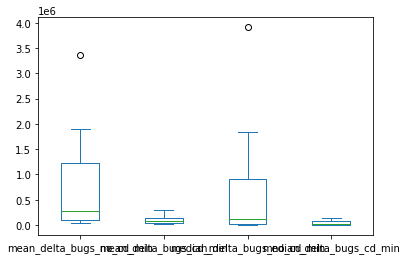

In [34]:
dfProjetosComCD[['name','cd_adoption_date','mean_delta_bugs_no_cd_min','mean_delta_bugs_cd_min', 'median_delta_bugs_no_cd_min','median_delta_bugs_cd_min' ]].to_csv('tabela1.csv', index=False)

CSV for Visualization

In [25]:
bugsCDProjects = issuesProjetosCD.query('issue_type == \'Bug\' & status == \'Closed\'')
bugsCDProjects['post_CD'] = False 
for i in range(dfProjetosComCD.shape[0]):
    tmp_date = dfProjetosComCD.loc[i,'cd_adoption_date']
    tmp_issue_sistem =  dfProjetosComCD.loc[i,'issues_system_id']
    bugsCDProjects.loc[(bugsCDProjects['issue_system_id']== tmp_issue_sistem) & (bugsCDProjects['created_at']>= tmp_date),'post_CD'] = True


In [26]:
bugsCDProjects[['_id','external_id','issue_system_id', 'created_at', 'updated_at','priority', 'affects_versions',  'resolution', 'original_time_estimate','post_CD'] ].to_csv('bugs_of_CD_projects.csv', index=False, sep=';')

Count Team contributors per project 

In [27]:
#dfProjetosComCD[['name','cd_adoption_date']].to_csv('contributors.csv',index=False)

In [28]:
issues.created_at.min(), issues.updated_at.max()

(Timestamp('2001-01-22 14:46:21'), Timestamp('2021-10-27 14:25:20.412000'))

In [29]:
p_values = []
for i in range(dfProjetosComCD.shape[0]):
    u,p = mannwhitneyu(bft_after, bft_before, alternative= "greater")

NameError: name 'bft_after' is not defined